# Pylops - acoustic wavefield separation of entire dataset with dipping seabed

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from stochmdd.calibrate import calibrate

## Data preparation

Let's import input data from file

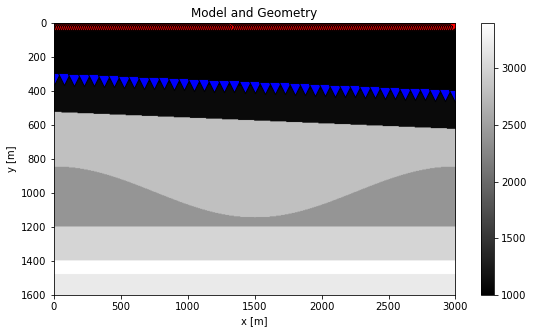

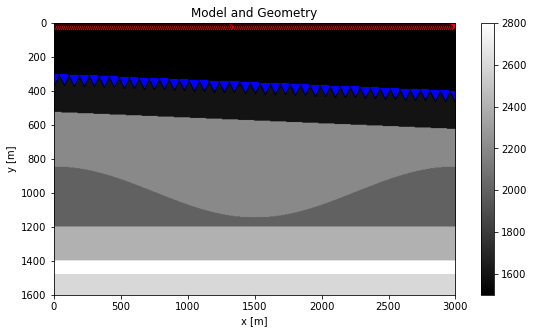

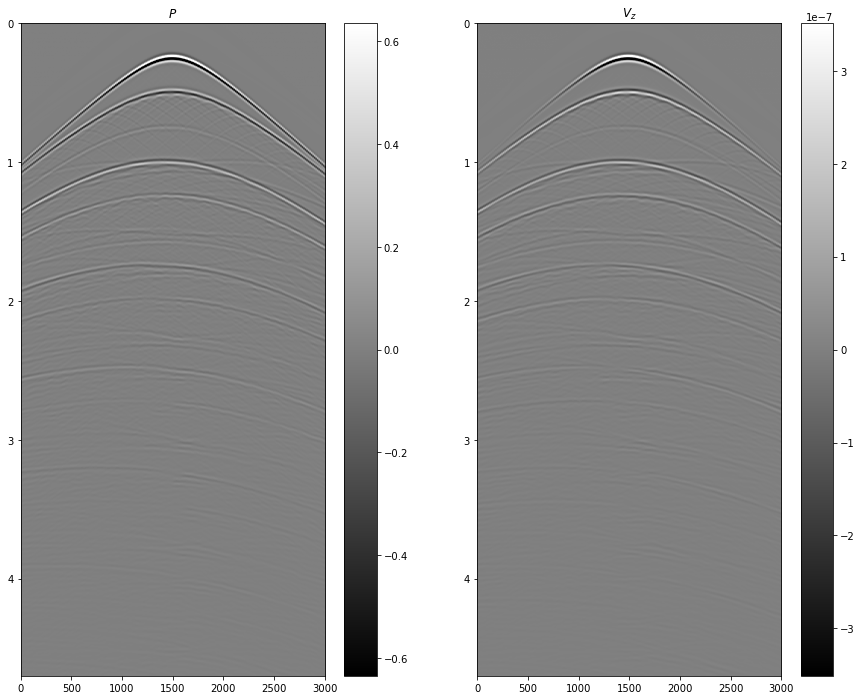

In [2]:
datapath = '../../data'
inputfile = os.path.join(datapath, 'input_dipping_recsolid.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1600.0 # velocity at separation level
rho_sep = 1100.0 # density at separation level

#method = 'sum'
#method = 'rec_ana'
method = 'src_ana'
#method = 'src_inv'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
r = r[:, 201:]
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 941, 0.005
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

# Data
p = inputdata['p']
vz = inputdata['vz']
vx = inputdata['vz']


p = np.apply_along_axis(convolve, 1, p, wav, mode='full')
p = p[:, wav_c:][:, :nt]
vz = np.apply_along_axis(convolve, 1, vz, wav, mode='full')
vz = vz[:, wav_c:][:, :nt]
vx = np.apply_along_axis(convolve, 1, vx, wav, mode='full')
vx = vx[:, wav_c:][:, :nt]

# Normalize
vz /= p.max()
vx /= p.max()
p /= p.max()

clip=0.5

plt.figure(figsize=(9,5))
im = plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

fig, axs = plt.subplots(1, 2, figsize=(15,12))
im=axs[0].imshow(p[ns//2], cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$P$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(vz[ns//2], cmap='gray', vmin=-clip*np.abs(vz).max(), vmax=clip*np.abs(vz).max(),
                 extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$V_z$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1]);

Rotate vz

In [3]:
seabed_dip = np.rad2deg(np.tan((r[1,-1] -r[1,0]) / (r[0,-1] - r[0,0])))
sin_dip = np.sin(np.deg2rad(seabed_dip))
cos_dip = np.cos(np.deg2rad(seabed_dip))

vz = vz * cos_dip - vx * sin_dip

## Wavefield separation

Create frequency-wavenumber spectra (using PyLops FFT2D)

In [4]:
nfft=2**11
FFTop = FFT2D(dims=[nr, nt], 
              nffts=[nfft, nfft], sampling=[dr, dt])
dottest(FFTop, nfft*nfft, nt*nr, complexflag=2)

True

Create separation operators

In [5]:
critical = 0.9
ntaper = 9 # 7
cutoff = 1e7 # 1e8

#obliquity factor
[Kx, F] = np.meshgrid(FFTop.f1, FFTop.f2, indexing='ij')
k=F/vel_sep
Kz=np.sqrt((k**2-Kx**2).astype(np.complex))
Kz[np.isnan(Kz)] = 0

# obliquities
OBL=rho_sep*(np.abs(F)/Kz)
OBL[Kz==0]=0
OBL[OBL>cutoff]=0

OBL1 = Kz /(rho_sep*np.abs(F))
OBL1[F==0] = 0
OBL1[OBL1<1./cutoff]=0

# cut off and taper
mask = np.abs(Kx)<critical*np.abs(F)/vel_sep
mask = filtfilt(np.ones(ntaper)/float(ntaper), 1, mask, axis=0)
mask = filtfilt(np.ones(ntaper)/float(ntaper), 1, mask, axis=1)

OBL = OBL*mask
OBL1 = OBL1*mask

# analytical separation
Maskop = Diagonal(mask.ravel(), dtype='complex128')
OBLop = Diagonal(OBL.ravel(), dtype='complex128')

Sop = 0.5*(BlockDiag([FFTop.H, FFTop.H])*\
    Block([[Maskop, OBLop],
           [Maskop, -OBLop]])*\
           BlockDiag([FFTop, FFTop]))

In [6]:
# calibration params
twin = [0.01, 0.07]
nfilt = 15

In [7]:
pup = np.zeros((ns, nt, nr))
pdown = np.zeros((ns, nt, nr))
    
if method == 'sum':
    for isrc in range(0,ns):
        if isrc % 10 == 0:
            print(f'Working with source {isrc}/{ns}')
        vzcalib = calibrate(p[isrc].T, vz[isrc].T, s, r, isrc, dt, nt, vel_dir, vel_sep, 
                            rho_sep, twin=twin, nfilt=nfilt, plotflag=False)
        
        pdown[isrc] = (p[isrc] + vzcalib.T*(rho_sep*vel_sep) ) / 2.
        pup[isrc] = (p[isrc] - vzcalib.T*(rho_sep*vel_sep) ) / 2.

elif method == 'src_ana':
    for isrc in range(0,ns):
        if isrc % 10 == 0:
            print(f'Working with source {isrc}/{ns}')
        vzcalib = calibrate(p[isrc].T, vz[isrc].T, s, r, isrc, dt, nt, vel_dir, vel_sep, 
                            rho_sep, twin=twin, nfilt=nfilt, plotflag=False)
        
        d = np.concatenate((p[isrc].T.ravel(), vzcalib.ravel()))
        dud = np.real(Sop*d)

        d = d.reshape(2*nr, nt)
        dud = dud.reshape(2*nr, nt)
        pdown[isrc], pup[isrc] = dud[:nr].T, dud[nr:].T
        
elif method == 'rec_ana':
    for irec in range(nr):
        if irec % 10 == 0:
            print(f'Working with receiver {irec}/{nr}')

        vzcalib = calibrate(p[..., irec], vz[..., irec], r, s, irec, dt, nt, vel_dir, vel_sep, rho_sep,
                            twin=twin, nfilt=nfilt, plotflag=False)
        
        d = np.concatenate((p[...,irec].ravel(), vzcalib.ravel()))
        dud = np.real(Sop*d)

        d = d.reshape(2*ns, nt)
        dud = dud.reshape(2*ns, nt)
        pdown[...,irec], pup[...,irec] = dud[:ns], dud[ns:]

elif method == 'src_inv':
    for isrc in range(ns):
        if isrc % 10 == 0:
            print(f'Working with source {isrc}/{ns}')
        vzcalib = calibrate(p[isrc].T, vz[isrc].T, s, r, isrc, dt, nt, vel_dir, vel_sep, 
                            rho_sep, twin=twin, nfilt=nfilt, plotflag=False)
        
        # separation by inversion
        OBLop = Diagonal(OBL1.flatten(), dtype='complex128')
        Maskop = Diagonal(mask.flatten(), dtype='complex128')

        S1op_scaled = (BlockDiag([FFTop.H, (p[isrc].max()/vzcalib.max())*FFTop.H])*\
                Block([[Maskop, Maskop],
                       [OBLop, -OBLop]]) * BlockDiag([FFTop, FFTop]))

        d = np.concatenate((FFTop.H * Maskop * FFTop * p[isrc].T.flatten(), 
                            (p[isrc].max()/vzcalib.max()) * FFTop.H * Maskop * FFTop * vzcalib.flatten()))
        
        dud_inv, istop, itn, r1norm, r2norm = \
            lsqr(S1op_scaled, d.flatten(), damp=1e-10, 
                 iter_lim=10, show=0)[0:5]
        dud_inv = np.real(dud_inv)
        dud_inv = dud_inv.reshape(2*nr, nt)

        pdown_inv, pup_inv= dud_inv[:nr], dud_inv[nr:]

        # clean up data outside of spectral cone
        pdown_inv = np.real(np.reshape(FFTop.H * Maskop * FFTop * pdown_inv.ravel(), (nr, nt)))
        pup_inv = np.real(np.reshape(FFTop.H * Maskop * FFTop * pup_inv.ravel(), (nr, nt)))

        # clean up data outside of spectral cone
        pdown[isrc] = pdown_inv.T
        pup[isrc] = pup_inv.T

Working with source 0/201
Working with source 10/201
Working with source 20/201
Working with source 30/201
Working with source 40/201
Working with source 50/201
Working with source 60/201
Working with source 70/201
Working with source 80/201
Working with source 90/201
Working with source 100/201
Working with source 110/201
Working with source 120/201
Working with source 130/201
Working with source 140/201
Working with source 150/201
Working with source 160/201
Working with source 170/201
Working with source 180/201
Working with source 190/201
Working with source 200/201


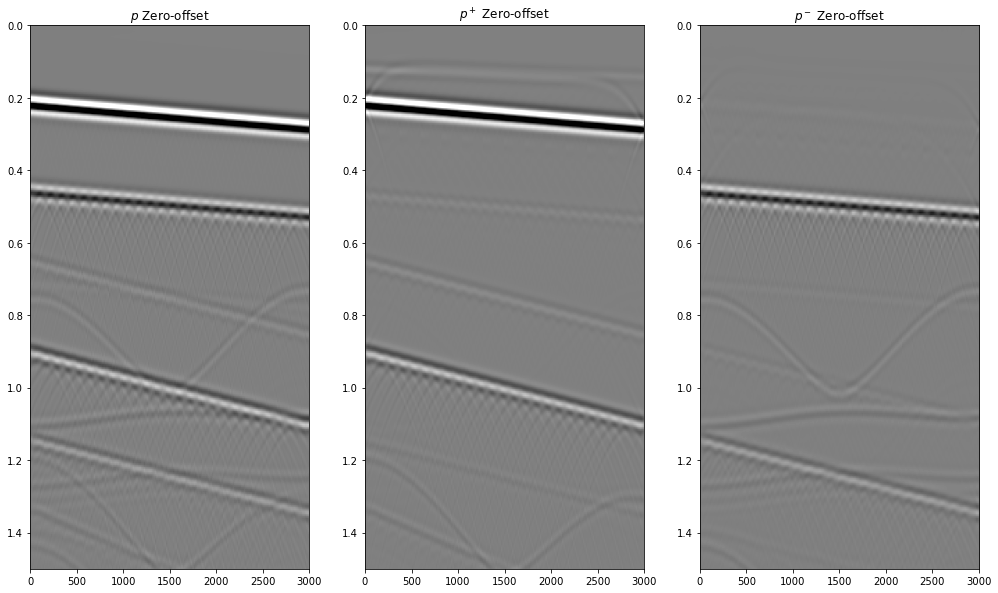

In [8]:
p_zo = np.zeros((ns, nt))
pup_zo = np.zeros((ns, nt))
pdown_zo = np.zeros((ns, nt))

for isrc in range(ns):
    irec_zo = np.argmin(np.abs(s[0, isrc]-r[0]))
    p_zo[isrc] = p[isrc, :, irec_zo]
    pup_zo[isrc], pdown_zo[isrc] = pup[isrc, :, irec_zo], pdown[isrc, :, irec_zo]
    
fig, axs = plt.subplots(1, 3, figsize=(17,10))
axs[0].imshow(p_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$p$ Zero-offset')
axs[0].axis('tight')
axs[0].set_ylim(1.5, 0)
axs[1].imshow(pdown_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$p^+$ Zero-offset')
axs[1].axis('tight')
axs[1].set_ylim(1.5, 0)
axs[2].imshow(pup_zo.T, cmap='gray', vmin=-clip*np.abs(p_zo).max(), vmax=clip*np.abs(p_zo).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$p^-$ Zero-offset')
axs[2].axis('tight')
axs[2].set_ylim(1.5, 0);

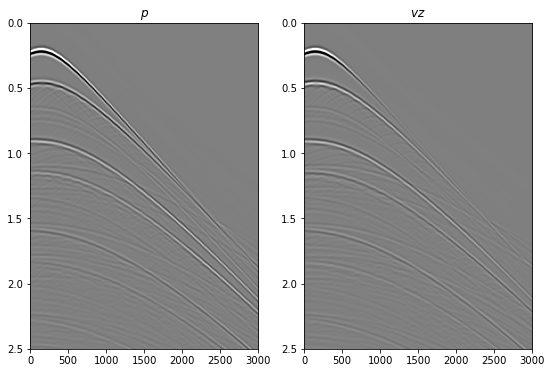

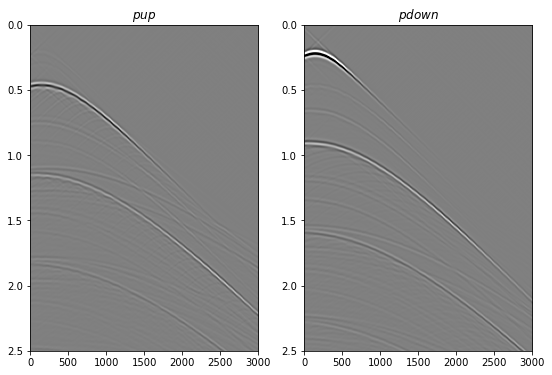

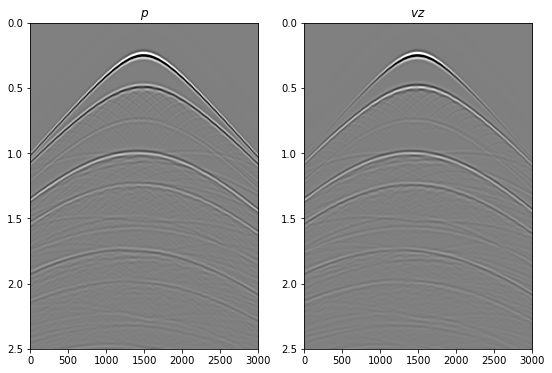

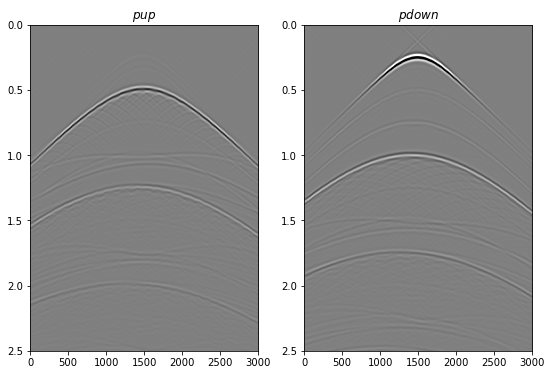

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p[10], cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow(vz[10], cmap='gray', vmin=-clip*np.abs(vz).max(), vmax=clip*np.abs(vz).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$vz$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0)

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[10], cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow(pdown[10], cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0);


fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(p[ns//2], cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$p$')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow(vz[ns//2], cmap='gray', vmin=-clip*np.abs(vz).max(), vmax=clip*np.abs(vz).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$vz$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0)

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[ns//2], cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[0].set_ylim(2.5, 0)
axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight')
axs[1].set_ylim(2.5, 0);

In [10]:
#np.savez(os.path.join(datapath, 'updown_dipping_belowseabed_%s' % method), pup=pup, pdown=pdown)

## MDD

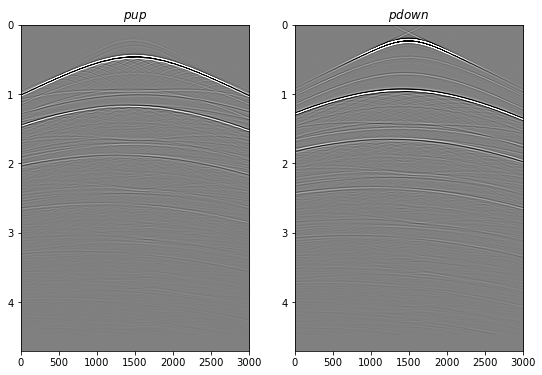

In [11]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0))).astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0))).astype('float32')
ntpad = pup.shape[1]

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight');

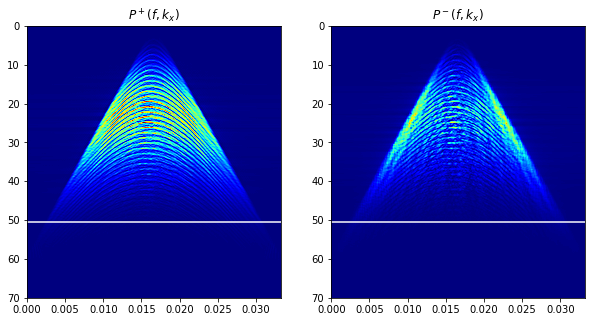

In [12]:
# check max frequency to use
nfmax = 250
nfft = ntpad

FFTop = FFT2D(dims=[nr, ntpad], nffts=[nfft, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[ns//2].T.flatten()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(70, 0);
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight');
axs[1].set_ylim(70, 0);           

In [13]:
# Invert for model (MDD)
Rinv,Radj = MDD(pdown.transpose(0, 2, 1), pup.transpose(0, 2, 1), dt=dt, dr=dr, 
                nfmax=nfmax, twosided=False, 
                adjoint=True, psf=False, dtype='complex64', dottest=True, 
                **dict(damp=1e-10, iter_lim=20, show=1))

Dot test passed, v^T(Opu)=-239984.065571 - u^T(Op^Tv)=-239984.065571
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 40037391 rows and 40037391 columns
damp = 1.00000000000000e-10   calc_var =        0
atol = 1.00e-08                 conlim = 1.00e+08
btol = 1.00e-08               iter_lim =       20
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.791e+02  1.791e+02    1.0e+00  1.2e+00
     1  2.26912e-04   1.062e+02  1.062e+02    5.9e-01  5.9e-01   2.6e+02  1.0e+00
     2  6.27540e-04   7.778e+01  7.778e+01    4.3e-01  4.0e-01   3.6e+02  2.2e+00
     3  1.07287e-03   5.973e+01  5.973e+01    3.3e-01  3.0e-01   4.6e+02  3.8e+00
     4  1.47384e-03   4.811e+01  4.811e+01    2.7e-01  2.4e-01   5.4e+02  5.4e+00
     5  1.85759e-03   3.997e+01  3.997e+01    2.2e-01  1.9e-01   6.1e+02  7.3e+00
     6  2.25001e-03   3.392e+01  3.392e+01    1.9e-01  1.5e-01   6.7e+02  9.1e+00
     7  2.61889e-03   2.963e+01  2.963e

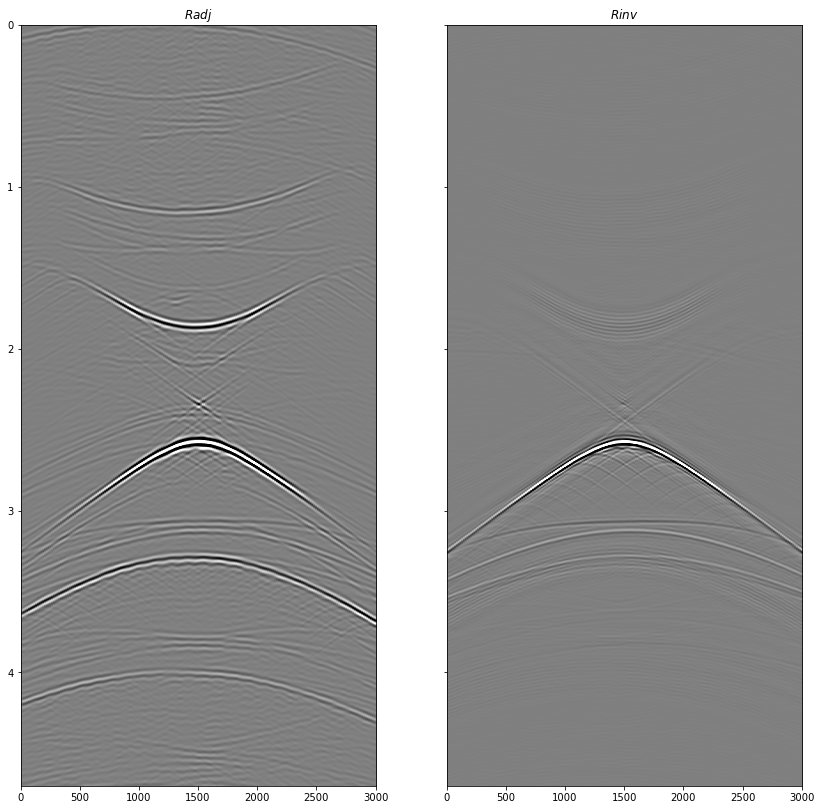

In [14]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(14,14))
axs[0].imshow(np.fft.fftshift(Radj[ns//2].T, axes=0), cmap='gray', 
           vmin=-0.2*np.abs(Radj).max(), vmax=0.2*np.abs(Radj).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(np.fft.fftshift(Rinv[ns//2].T, axes=0), cmap='gray', 
           vmin=-0.2*np.abs(Rinv).max(), vmax=0.2*np.abs(Rinv).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight');

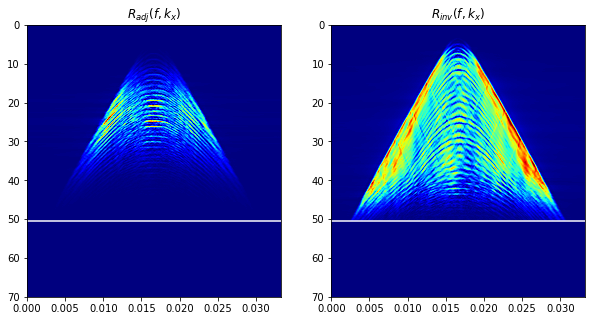

In [15]:
RADJ = (FFTop*Radj[ns//2].ravel()).reshape(nfft, nfft)
RINV = (FFTop*Rinv[ns//2].ravel()).reshape(nfft, nfft)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(RADJ[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RADJ).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$R_{adj}(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(70, 0);
im=axs[1].imshow(np.fft.fftshift(np.abs(RINV[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RINV).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$R_{inv}(f, k_x)$')
axs[1].axis('tight');
axs[1].set_ylim(70, 0);           

Compare results with wavefield modelled without free-surface

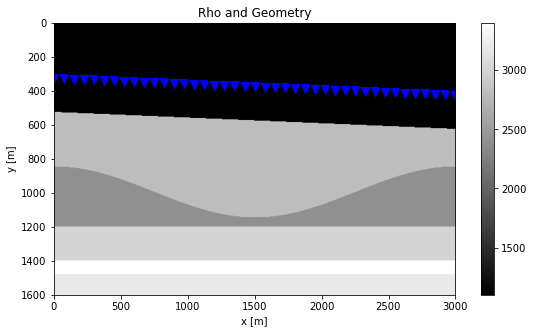

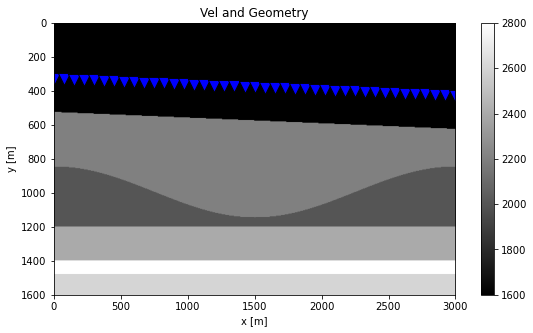

In [16]:
inputfile = os.path.join(datapath, 'input_dipping_noseabed_recsolid.npz')
inputdata = np.load(inputfile)

# data
R = inputdata['vz_noseabed']

# Model
rho_ref = inputdata['rho_noseabed']
vel_ref = inputdata['vel_noseabed']

plt.figure(figsize=(9,5))
im = plt.imshow(rho_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Rho and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Vel and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

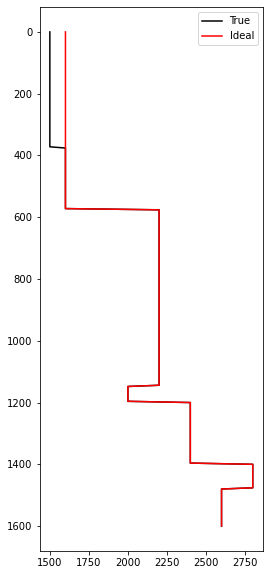

In [17]:
plt.figure(figsize=(4, 10))
plt.plot(vel[:, len(x)//2], z, 'k', label='True')
plt.plot(vel_ref[:, len(x)//2], z, 'r', label='Ideal')
plt.legend()
plt.gca().invert_yaxis()

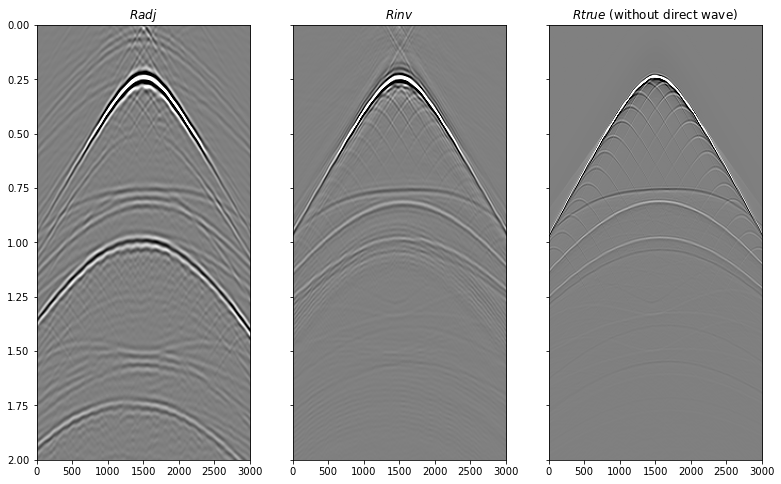

In [18]:
clip = 0.2
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(13,8))
axs[0].imshow(Radj[ns//2, :, :nt].T, cmap='gray', vmin=-clip*np.abs(Radj).max(), vmax=clip*np.abs(Radj).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$Radj$')
axs[0].axis('tight')
axs[1].imshow(Rinv[ns//2, :, :nt].T, cmap='gray', vmin=-clip*np.abs(Rinv).max(), vmax=clip*np.abs(Rinv).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$Rinv$')
axs[1].axis('tight')
axs[2].imshow(-R, cmap='gray', vmin=-clip*np.abs(R).max(), vmax=clip*np.abs(R).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'$Rtrue$ (without direct wave)')
axs[2].axis('tight')
axs[2].set_ylim(2., 0);

In [19]:
#np.savez(os.path.join(datapath, 'mdd_dipping_belowseabed_%s' % method), Radj=Radj, Rinv=Rinv)